# Creating NBA Shot Charts with Python

## Dependencies

In [71]:
from nba_api.stats.endpoints import shotchartdetail, playercareerstats
from nba_api.stats.static import players, teams
from modules.datasets import Datasets
import json
import requests
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

## Load Data
### Finding IDs of PLayer and Team to get the Data

In [72]:
# get player id
name = "Isaiah Thomas"
id = Datasets.get_json_from_name(name)['id']
print(f'{name} id: {id}')

Isaiah Thomas id: 202738


In [73]:
career = Datasets.get_player_career(id)
team_id = career[career.TEAM_ABBREVIATION == 'BOS'].TEAM_ID.values[0]
print(f'{name} team id: {team_id}')

Isaiah Thomas team id: 1610612738


### Get Data

In [74]:
season = '2016-17'
shot_json = shotchartdetail.ShotChartDetail(
    team_id=team_id,
    player_id=id,
    season_nullable=season,
    context_measure_simple='FGA'
)

In [75]:
shot_data = shot_json.get_data_frames()[0]
shot_data.head()

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
0,Shot Chart Detail,0021600006,25,202738,Isaiah Thomas,1610612738,Boston Celtics,1,8,56,...,Right Side Center(RC),24+ ft.,24,212,121,1,0,20161026,BOS,BKN
1,Shot Chart Detail,0021600006,34,202738,Isaiah Thomas,1610612738,Boston Celtics,1,7,54,...,Center(C),24+ ft.,25,64,244,1,0,20161026,BOS,BKN
2,Shot Chart Detail,0021600006,40,202738,Isaiah Thomas,1610612738,Boston Celtics,1,7,3,...,Center(C),Less Than 8 ft.,4,-25,36,1,0,20161026,BOS,BKN
3,Shot Chart Detail,0021600006,46,202738,Isaiah Thomas,1610612738,Boston Celtics,1,6,18,...,Center(C),Less Than 8 ft.,1,-17,3,1,1,20161026,BOS,BKN
4,Shot Chart Detail,0021600006,54,202738,Isaiah Thomas,1610612738,Boston Celtics,1,5,59,...,Center(C),24+ ft.,25,63,242,1,0,20161026,BOS,BKN


### Data Analysis

In [76]:
shot_data.columns

Index(['GRID_TYPE', 'GAME_ID', 'GAME_EVENT_ID', 'PLAYER_ID', 'PLAYER_NAME',
       'TEAM_ID', 'TEAM_NAME', 'PERIOD', 'MINUTES_REMAINING',
       'SECONDS_REMAINING', 'EVENT_TYPE', 'ACTION_TYPE', 'SHOT_TYPE',
       'SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE', 'SHOT_DISTANCE',
       'LOC_X', 'LOC_Y', 'SHOT_ATTEMPTED_FLAG', 'SHOT_MADE_FLAG', 'GAME_DATE',
       'HTM', 'VTM'],
      dtype='object')

In [77]:
shot_data.SHOT_MADE_FLAG.value_counts(normalize=True).head()

0    0.536999
1    0.463001
Name: SHOT_MADE_FLAG, dtype: float64

In [78]:
shot_data.SHOT_ZONE_BASIC.value_counts(normalize=True)

Above the Break 3        0.379498
Restricted Area          0.359810
Mid-Range                0.103191
In The Paint (Non-RA)    0.098439
Right Corner 3           0.040054
Left Corner 3            0.019009
Name: SHOT_ZONE_BASIC, dtype: float64

In [79]:
shot_data.SHOT_ZONE_BASIC.unique()

array(['Above the Break 3', 'In The Paint (Non-RA)', 'Restricted Area',
       'Mid-Range', 'Left Corner 3', 'Right Corner 3'], dtype=object)

In [80]:
print("Tipos de arremesso mais comuns:")
shot_data.ACTION_TYPE.value_counts(normalize=True).head(10)

Tipos de arremesso mais comuns:


Jump Shot                         0.416158
Pullup Jump shot                  0.144603
Driving Layup Shot                0.119484
Driving Finger Roll Layup Shot    0.082145
Layup Shot                        0.063815
Driving Floating Jump Shot        0.023761
Running Layup Shot                0.022403
Driving Reverse Layup Shot        0.020367
Step Back Jump shot               0.019009
Fadeaway Jump Shot                0.011541
Name: ACTION_TYPE, dtype: float64

## Create Shot Chart

### Create Court

In [81]:
def create_court(ax, color):
    
    # Short corner 3PT lines
    ax.plot([-220, -220], [0, 140], linewidth=2, color=color)
    ax.plot([220, 220], [0, 140], linewidth=2, color=color)
    
    # 3PT Arc
    ax.add_artist(mpl.patches.Arc((0, 140), 440, 315, theta1=0, theta2=180, facecolor='none', edgecolor=color, lw=2))
    
    # Lane and Key
    ax.plot([-80, -80], [0, 190], linewidth=2, color=color)
    ax.plot([80, 80], [0, 190], linewidth=2, color=color)
    ax.plot([-60, -60], [0, 190], linewidth=2, color=color)
    ax.plot([60, 60], [0, 190], linewidth=2, color=color)
    ax.plot([-80, 80], [190, 190], linewidth=2, color=color)
    ax.add_artist(mpl.patches.Circle((0, 190), 60, facecolor='none', edgecolor=color, lw=2))
    ax.plot([-250, 250], [0, 0], linewidth=4, color='white')
    
    # Rim
    ax.add_artist(mpl.patches.Circle((0, 60), 15, facecolor='none', edgecolor=color, lw=2))
    
    # Backboard
    ax.plot([-30, 30], [40, 40], linewidth=2, color=color)
    
    # Remove ticks
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Set axis limits
    ax.set_xlim(-250, 250)
    ax.set_ylim(0, 470)
    
    return ax

### Calculate Percentages by Court Zone

In [82]:
# Chart common parameters
gridsize = 25
cmap = "inferno"
extent=(-250, 250, 422.5, -47.5)

In [83]:
# create frequency of shots per hexbin zone
shots_hex = plt.hexbin(
    shot_data.LOC_X, shot_data.LOC_Y + 60,
    extent=extent, cmap=cmap, gridsize=gridsize)
plt.close()
shots_hex_array = shots_hex.get_array()
freq_by_hex = shots_hex_array / sum(shots_hex_array)
sizes = freq_by_hex * 120

In [84]:
# create field goal % per hexbin zone
makes_df = shot_data[shot_data.SHOT_MADE_FLAG == 1] # filter dataframe for made shots
makes_hex = plt.hexbin(makes_df.LOC_X, makes_df.LOC_Y + 60, cmap=cmap,
                gridsize=gridsize, extent=extent) # create hexbins
plt.close()
pcts_by_hex = makes_hex.get_array() / shots_hex.get_array()
pcts_by_hex[np.isnan(pcts_by_hex)] = 0  # convert NAN values to 0

In [85]:
# filter data for zone with at least 5 shots made
sample_sizes = shots_hex.get_array()
filter_threshold = 5
for i in range(len(pcts_by_hex)):
    if sample_sizes[i] < filter_threshold:
        pcts_by_hex[i] = 0
x = [i[0] for i in shots_hex.get_offsets()]
y = [i[1] for i in shots_hex.get_offsets()]
z = pcts_by_hex

## Shotchart

In [86]:
freq_by_hex_categorical = pd.cut(freq_by_hex, 3, labels=[1, 2, 3]).astype(int)
sizes = freq_by_hex * 1000

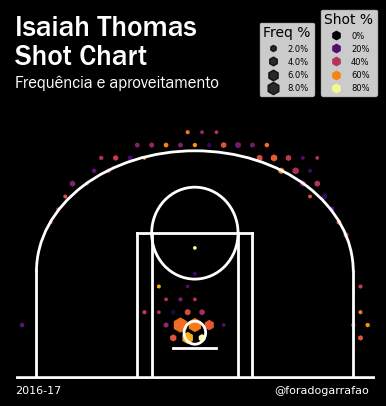

In [99]:
# Create figure and axes
fig = plt.figure(figsize=(3.6, 3.6), facecolor='black', edgecolor='black', dpi=100)
ax = fig.add_axes([0, 0, 1, 1], facecolor='black')
plt.xlim(250, -250)
plt.ylim(-47.5, 422.5)

# Plot hexbins
scatter = ax.scatter(x, y, c=z, cmap=cmap, marker='h', s=sizes)

# Draw court
ax = create_court(ax, 'white')

# Add legends
max_freq = max(freq_by_hex)
max_size = max(sizes)
legend_acc = plt.legend(
    *scatter.legend_elements(num=5, fmt="{x:.0f}%",
                             func=lambda x: x * 100),
    loc=[0.85,0.785], title='Shot %', fontsize=6)
legend_freq = plt.legend(
    *scatter.legend_elements(
        'sizes', num=5, alpha=0.8, fmt="{x:.1f}%"
        , func=lambda s: s / max_size * max_freq * 100
    ),
    loc=[0.68,0.785], title='Freq %', fontsize=6)
plt.gca().add_artist(legend_acc)

# Add title
plt.text(-250, 410, f"{name}\nShot Chart", fontsize=21, color='white',
         fontname='Franklin Gothic Medium')
plt.text(-250, 380, "Frequência e aproveitamento", fontsize=12, color='white',
         fontname='Franklin Gothic Book')
plt.text(-250, -20, season, fontsize=8, color='white')
plt.text(110, -20, '@foradogarrafao', fontsize=8, color='white')

plt.show()

## Volume of Shots Chart

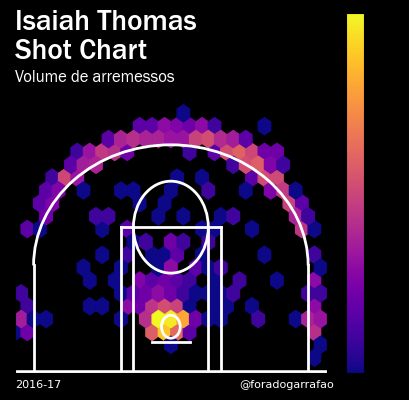

In [116]:
fig = plt.figure(figsize=(3.9, 3.6), facecolor='black', edgecolor='black', dpi=100)
ax = fig.add_axes([0, 0, 1, 1], facecolor='black')

# Plot hexbin of shots
hexbin = ax.hexbin(shot_data.LOC_X, shot_data.LOC_Y + 60, cmap='plasma',
          bins="log", gridsize=25, mincnt=2, extent=(-250, 250, 422.5, -47.5))
cb = fig.colorbar(hexbin, ax=ax)
#cb.set_label('Volume', fontsize=8, color='white')
#cb.set_ticklabels(color='white')

# Draw court
ax = create_court(ax, 'white')

# Annotate player name and season
plt.text(-250, 410, f"{name}\nShot Chart", fontsize=21, color='white',
         fontname='Franklin Gothic Medium')
plt.text(-250, 380, "Volume de arremessos", fontsize=12, color='white',
         fontname='Franklin Gothic Book')
plt.text(-250, -20, season, fontsize=8, color='white')
plt.text(110, -20, '@foradogarrafao', fontsize=8, color='white')

# Save and show figure
# plt.savefig('ShotChart.png', dpi=300, bbox_inches='tight')
plt.show()

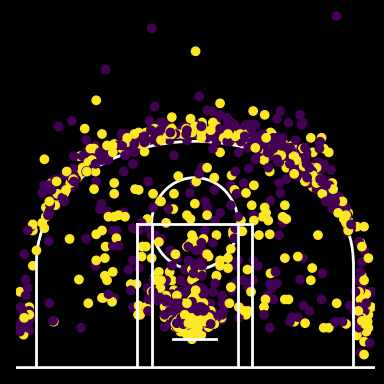

In [89]:
# Create figure and axes
fig = plt.figure(figsize=(3.6, 3.6), facecolor='black', edgecolor='black', dpi=100)
ax = fig.add_axes([0, 0, 1, 1], facecolor='black')

ax = create_court(ax, 'white')
ax.scatter(shot_data.LOC_X, shot_data.LOC_Y + 60, c=shot_data.SHOT_MADE_FLAG)


# contour plots